# ORIE 5355/INFO 5370 HW 2: Recommendation systems

 - Name: Kristen Flaherty
 - Net-id: kf293
 - Date: October 5, 2021 - 
 - Late days used for this assignment: 0
 - Total late days used (counting this assignment): 0
 - People with whom you discussed this assignment: Hayden Daly and Heisu Kim and Alex (unsure of last name)

After you finish the homework, please complete the following (short, anonymous) post-homework survey: https://forms.gle/5AG69LXM4yV3TL7o6 and include the survey completion code below.

### Question 0 [2 points]
<font color='blue'> Survey completion code:  hw22021abc

We have marked questions in <font color='blue'> blue </font>. Please put answers in black (do not change colors). You'll want to write text answers in "markdown" mode instead of code. In Jupyter notebook, you can go to Cell > Cell Type > Markdown, from the menu. Please carefully read the late days policy and grading procedure [here](https://orie5355.github.io/Fall_2021/assignments/). 

# Conceptual component

Go through the "Algorithms tour" [here](https://algorithms-tour.stitchfix.com/). It's a great view of the combination of algorithms used by a modern e-commerce company. 

<font color='blue'> 1) How do they use a combination of "latent" factors and explicit features to gain the benefits of collaborative filtering (matrix factorization) while not being susceptible to cold start issues?

StithFix uses ranking and collaborative filtering to create a normal matrix factorization (+ user- and content-similarty based recommendation systems) with explicit features of each user (their preferences and/or orders or likes on specific items that were clearly given to the website) and of each item (clothing tags that help identify and distinguish items in the StitchFix warehouse), that also includes latent features for both users and items. These latent user features are predicted from 'near' or simliar users who have liked items that the user of interest has not yet seen, while latent item features are predicted by examining the range of fit, style or other item characteristics of items that the user of interest has already looked at, liked or purchased. Even if the user of interest doesn't input lots of data about their preferences upon signing up, StitchFix can predict latent features about the user and items based on comparisons across similar users, using the data they do have about this user of interest.

<font color='blue'> 2) How do they match clients with human stylists who make the final decision? Does it remind you of anything we learned in class?

StitchFix uses a bootstrapped method similar to the one described above using user-based similarity, content-based similarity, and matrix factorization methods. They calculate the distance beteween a user and client's explicit and latent features, and also incorporate priors (whether the two have ever worked together). The constraints in this problem are that the users must have submitted a shipment, and the work pile for the stylist must not be overloaded. These constraints make it impossible for StitchFix to choose the maximum 'match score' from the matching computations and within the factorization matrix. This is a similar problem to what we discussed in class: what do we do with the predictions once we have them, especially if we have a limited capacity of items (or stylists in this case), and if we have multi-sided preferences (between users and stylists here)?

<font color='blue'> 3) How do they manage their inventory to ensure that they have enough items that future customers will want?

StitchFix uses historical data of users and items purchased to determine the allocation of items to different warehouses, purchases of new items at the right time to keep costs down and fill future demands. To do this, they predict what users will want in the future (and which items to keep or buy) by recording the states of users when thye shop, detect changes in their states and any triggers to those state changes via state transition matrices and Markov chain models. They use the same method on items (changes and triggers to item selection) to predict future fashion trends and future demand of items. 

# Programming component

## Helper code

In [1]:
import numpy as np
import pandas as pd
import os, sys, math
import matplotlib.pyplot as plt
import pickle
def load_pickle(filename):
    with open(filename, "rb") as f:
        data = pickle.load(f)
    return data

def load_ratings_and_factors(type_name = 'interaction'):
    ratings = load_pickle('data/{}_ratings'.format(type_name))
    book_vectors = load_pickle('data/{}_dict_book_factor'.format(type_name))
    user_vectors = load_pickle('data/{}_dict_reader_factor'.format(type_name))
    return ratings, book_vectors, user_vectors

In this homework, we are giving you trained user and book item vectors using a GoodReads dataset. Goodreads is a social cataloging website that allows individuals to search its database of books, annotations, quotes, and reviews. There are multiple types of interactions that a user can have with a book: add books to a list of books they intend to read ("short-list" the book), indicate they have read books before, and review books they have read. 

Here, we work with multiple types of interactions as training data for a recommendation system. For each "type" of rating data, we give you the raw ratings data, as well as user and item vectors trained using a Python package (https://berkeley-reclab.github.io/) that implements matrix factorization in cases where there are missing entries in a matrix. The "ratings" data is in a "sparse matrix"/dictionary format, meaning that the dictionary keys are of the kind (user, item), and the dictionary value is the corresponding value. Not all pairs are in the matrix, indicating that that value is missing or at its default value. 

There are 4 types of rating/interaction data:

 - `Interaction`: a "1" indicates the user has interacted with the book at some point in the past, either by saying that they intend to read it, have read it, or have given it a rating. If it is missing, that means the user has not interacted with the book.
 
 - `Explicit Rating`: explicit ratings. Numeric values indicate the ratings given. If it is missing, that means the user has not rated the book.
  
 - `Rating_all_zero`: explicit ratings. Numeric values more than 0 indicate the ratings given. Now, we replace missing values from above with "zeros," so that there are no missing ratings.
 
 - `Rating_interaction_zero`: explicit ratings. Numeric values more than 0 indicate the ratings given. Now, we replace missing values from above with "zeros," only if the user interacted with that book in the past.

In [2]:
ratings_interactions, book_vectors_interactions, user_vectors_interactions = load_ratings_and_factors(type_name = 'interaction')
ratings_explicit, book_vectors_explicit, user_vectors_explicit = load_ratings_and_factors(type_name = 'rating')
ratings_allmissing0, book_vectors_allmissing0, user_vectors_allmissing0 = load_ratings_and_factors(type_name = 'rating_all_zero')
ratings_interact0, book_vectors_interact0, user_vectors_interact0 = load_ratings_and_factors(type_name = 'rating_interaction_zero')


In [3]:
def get_shapes_and_ranges(ratings, book_vectors, item_vectors):
    print(len(ratings), np.shape(book_vectors), np.shape(item_vectors), min(ratings.values()), max(ratings.values()))

In [4]:
get_shapes_and_ranges(ratings_interactions, book_vectors_interactions, user_vectors_interactions)
get_shapes_and_ranges(ratings_explicit, book_vectors_explicit, user_vectors_explicit)
get_shapes_and_ranges(ratings_allmissing0, book_vectors_allmissing0, user_vectors_allmissing0)
get_shapes_and_ranges(ratings_interact0, book_vectors_interact0, user_vectors_interact0)

12238 (200, 10) (1000, 10) 1 1
8324 (200, 10) (1000, 10) 1 5
200000 (200, 10) (1000, 10) 0 5
12238 (200, 10) (1000, 10) 0 5


## Problem 1: Predictions and recommendations with different data types

### 1a) What do different data types mean?

<font color='blue'> What is `Rating_interaction_zero` trying to capture -- why would we fill in books that someone interacted with but did not rate as a 0? (Hint: connect to conceptual reading from HW1). Answer in no more than 3 sentences. 

Rating_interaction_zero includes all of the books and all of the users' interactions with each book, even if the user didn't rate the book (value of 0) or didn't interact with a book (missing value). It's important for us to know that someone interacted with a book especially if they didn't rate it because we can then identify this as differential non response and investigate if they were less likely to rate it because they didn't like it, didn't end up reading it, or for some other reason. 

<font color='blue'> What are some potential problems you see with using `rating_all_zero` for recommendations? Answer in no more than 3 sentences.
    
    

In rating_all_zero, we don't know if the user failed to rate the book (value of 0) because they didn't like the book after reading it, or just never read the book. If we're using rating_all_zero to make recommendations to users about which books they should read, we might recommend repeat books that the user could have already read since we have no information on if they read it or not, or we might recommend completely dissimilar or unrelated books. This is a form of the cold start problem, but another problem is that we lack historical information about whether or not the user listed the book as 'on their list to read' or not.

### 1b) Generating predictions

<font color='blue'> Fill in the following function that takes in a user matrix (where each row is 1 user vector) and an item matrix (where each row is 1 item vector), and returns a matrix of predicted ratings for each user and item, where each entry is associated with the corresponding user (row number) and item (column number)

In [5]:
book_vectors_explicit.shape

(200, 10)

In [6]:
user_vectors_explicit.shape

(1000, 10)

In [7]:
def get_predictions(user_vectors, book_vectors):
    return np.dot(user_vectors, np.transpose(book_vectors))

In [8]:
predictions_expicit = get_predictions(user_vectors_explicit, book_vectors_explicit)
predictions_expicit.shape

(1000, 200)

<font color='blue'> Output the predictions for first 10 items for the first user, using each of the 4 data types

In [9]:
datatypes = {'interactions':(user_vectors_interactions, book_vectors_interactions),
             'explicit ratings':(user_vectors_explicit, book_vectors_explicit),
            'ratings zeros':(user_vectors_allmissing0, book_vectors_allmissing0),
            'interactions zeros': (user_vectors_interact0, book_vectors_interact0)}


In [10]:
# use below for 2c, last 100 vectors

In [11]:
for typ, data in datatypes.items():
    preds = get_predictions(data[0], data[1])
    print("First user's 10 item predictions- {}:".format(typ))
    print(preds[0][:10])
    print('\n')

First user's 10 item predictions- interactions:
[-0.00268685  0.01007861  0.00173543 -0.0009836   0.0029315   0.00733778
 -0.01030278  0.00722029  0.00110368  0.00335202]


First user's 10 item predictions- explicit ratings:
[ 0.07256422  0.40674721  0.07614967 -0.0750923   0.17636483  0.95914661
 -0.23892582 -0.00221766 -0.91204988  0.65839933]


First user's 10 item predictions- ratings zeros:
[ 0.08031172  0.28975416  0.06345163  1.5695302  -0.18567229  0.05502522
  0.01107722 -0.08822294 -0.89503553 -0.01175208]


First user's 10 item predictions- interactions zeros:
[-1.00879311  4.16663033 -0.91856862 -0.30194806 -2.52606751 -0.18905701
 -3.08103904 -0.53718459 -1.18618829 -1.21838417]




<font color='blue'> Do a scatterplot of the predicted rating for the "interaction" and "explicit ratings" types. (Each dot represents one user and one book, with X axis being predicted ratings using interaction data and Y axis being predicted rating using explicit ratings). Describe what you see in no more than 2 sentences. 

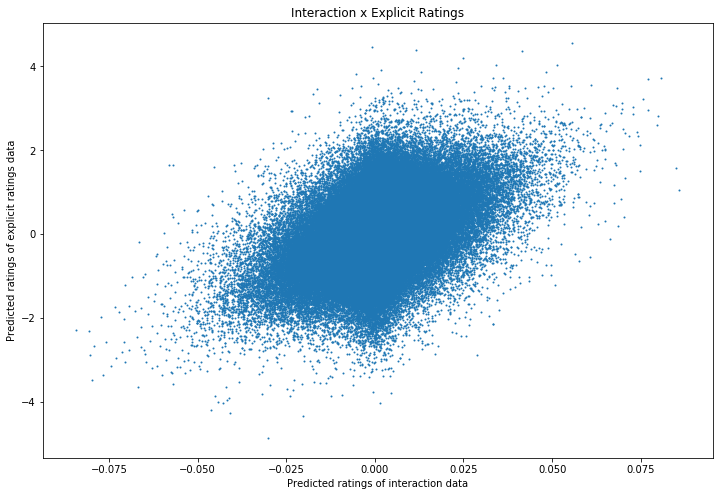

In [12]:
plt.figure(figsize=(12, 8))
plt.scatter(x=get_predictions(user_vectors_interactions, book_vectors_interactions).flatten(), y=get_predictions(user_vectors_explicit, book_vectors_explicit).flatten(), s = 1)
plt.title('Interaction x Explicit Ratings')
plt.xlabel('Predicted ratings of interaction data')
plt.ylabel('Predicted ratings of explicit ratings data')
plt.show()

In [13]:
from scipy import stats
r, p = stats.pearsonr(get_predictions(user_vectors_interactions, book_vectors_interactions).flatten(), get_predictions(user_vectors_explicit, book_vectors_explicit).flatten())
print('Pearson correlation between original predictions and new "simple method" predictions:', r, '\np-val:', p)

Pearson correlation between original predictions and new "simple method" predictions: 0.4272585025469964 
p-val: 0.0


**Observation**: There is a linear relationship between predictions based on the interaction data, and the predictions based on the explicit ratings data. The interaction data and explicit ratings predictions seem to be positively related to eaach other - almost similar.

### 1c) From predictions to recommendations (without capacity constraints)

<font color='blue'> Fill in the following function that takes in the matrix predicted ratings for each user and item, returns a dictioanry where the keys are the user indices and the values are a list of length "number_top_items" indicating the recommendations given to that user

In [280]:
def get_recommendations_for_each_user(predictions, number_top_items = 10):
    
    recs_l = []

    for user in range(preds.shape[0]):
        recs = {val:i for i, val in enumerate(preds[user])}
        recs_l.append([recs[i] for i in sorted(recs.keys())[::-1][:number_top_items]])

    return recs_l

<font color='blue'> Output the recommendations for the first user, using each of the 4 data types

In [281]:
for typ, data in datatypes.items():
    preds = get_predictions(data[0], data[1])
    recs = get_recommendations_for_each_user(preds)
    print('Recommendations for the first user - {}'.format(typ))
    print('Items:', recs[0])
    print('\n')

Recommendations for the first user - interactions
Items: [74, 164, 199, 30, 73, 104, 100, 19, 198, 182]


Recommendations for the first user - explicit ratings
Items: [30, 164, 121, 87, 199, 116, 108, 124, 5, 93]


Recommendations for the first user - ratings zeros
Items: [57, 55, 56, 81, 50, 78, 58, 86, 77, 96]


Recommendations for the first user - interactions zeros
Items: [166, 53, 1, 111, 170, 74, 182, 37, 73, 52]




<font color='blue'> Fill in the following function that takes in the recommendations for each user and item, and outputs a histogram for how often each item is to be recommended. For example, if there are 18 items, and 10 of them were never recommended, 5 of them were recommended once each, and 3 of them were recommended five times each, then you would have bars at 0, 1, and 5, of height 10, 5, and 3, respectively.

In [290]:
def show_frequency_histograms(recommendations):
    
    count = [0]*200

    for book in recommendations:
        for item in book:
            count[item] +=1
    
    return plt.hist(count) #value = X books (val, quantity of books) were recommended Y times (key)
#take count that each book is recommended and plot histogram of that (ex 100 books are recommended 3 times, etc)

<font color='blue'> Show the histograms for the "interact" and "explicit" data types. Describe what you observe in no more than 3 sentences. For example, discuss how often is the most recommended item recommended, how that compares to the least recommended items, and what that could mean for recommendations in various contexts. 

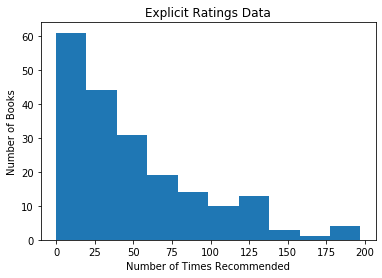

In [291]:
preds = get_predictions(user_vectors_explicit, book_vectors_explicit)
recs = get_recommendations_for_each_user(preds)

show_frequency_histograms(recs)
plt.title('Explicit Ratings Data')
plt.xlabel('Number of Times Recommended')
plt.ylabel('Number of Books')
plt.show()

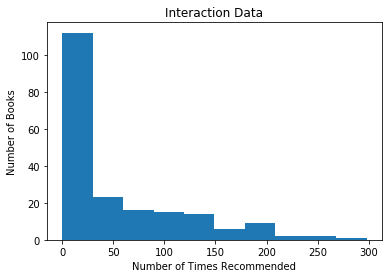

In [292]:
preds = get_predictions(user_vectors_interactions, book_vectors_interactions)
recs = get_recommendations_for_each_user(preds)

show_frequency_histograms(recs)

plt.title('Interaction Data')
plt.xlabel('Number of Times Recommended')
plt.ylabel('Number of Books')
plt.show()

**Observation:** There are discrepancies in how many books are recommended when using the explicit ratings data versus the interactions data. The most recommended items using the explicit ratings data do not get recommended nearly as often when using the interaction data. More books get recommended when using the explicit ratings data, while a lot of books (about half) don't get recommended at all when using the interaction data. This means that recommendation systems that rely only on interaction data is not enough to accurately recommend items to users. Also, there could be capacity constraints that are currently being ignored from this recommendation system, which means that the same limited items are being recommended to users (in the second histogram using interaction data).

# Problem 2: Cold start -- recommendations for new users

In this part of the assignment, we are going to ask you to tackle the "cold-start" problem with matrix-factorization based recommendation systems. The above recommendation techniques worked when you had access to past data for reach user, such as interactions or explicit ratings. However, it doesn't work as well when a new user has just joined the platform and so the platform doesn't have any data.  

You should also see a comma-separated values file (user_demographics.csv) that contains basic demographic information on each user. Each row describes one user, and have four attributes: 'User ID', 'Wealth', 'Age group' and 'Location'.

User ID is the unique identifier associated with each user, and it is in the same order as the user_vectors, and in the same indexing as the ratings (be careful about 0 and 1 indexing in Python).

Wealth is a non-negative, normalized value indicating the average wealth of the neighborhood in which the user is, where we normalized it such that each Location has similar wealth distributions. Age group describes the age of the user. Location describes the region that the user is from.

In [19]:
demographics = pd.read_csv("data/user_demographics.csv")
demographics.head()

,User ID,Wealth,Age group,Location
0,1,1.833101,50 to 64,America
1,2,2.194996,18 to 34,America
2,3,2.216195,18 to 34,Europe
3,4,0.838690,50 to 64,Asia Pacific
4,5,2.109313,18 to 34,America


We are now going to pretend that we don't have the personalized ratings/interactions history for the last 100 users, and thus don't have their user vectors. Rather, let's pretend that these are new users to the platform, and you are able to get the above demographics from their browswer cookies/IP address. Now, we're going to try to recommend items for them anyway. For this part, we'll exclusively use the "ratings with interaction0" data.

In [20]:
existing_user_vectors = user_vectors_interact0[0:900,:]
existing_user_demographics = demographics.iloc[0:900,:]
new_user_demographics = demographics.iloc[900:,:]

### 2a) Predictions for new users [Simple]

<font color='blue'> Fill in the following function that takes in: the demographics of a single new user, the demographics of all the existing users in your platform, and the user vectors of all the existing users, and outputs a 'predicted' user vector for the new user to use until we get enough data for that user. 
    
<font color='blue'> For this question, we ask you to use the following simple method to construct the vector for the new user. Each user is classified as "Low" or "High" wealth based on whether their Wealth score is below or above the median of 1.70. Then, we simply construct a mean user vector for "Low" and "High" wealth, based on the 900 users (take the average vector among users with "Low" and "High" Wealth, respectively.). The correpsonding mean vector is then used for each new user. 

In [24]:
median = existing_user_demographics.Wealth.median()
median

1.7026180771992308

In [25]:
low_wealth = existing_user_demographics[existing_user_demographics['Wealth'] < median]

In [293]:
def get_user_vector_for_new_user(new_user, existing_user_demographics, existing_user_vectors):
    
    median = existing_user_demographics.Wealth.median()
    
    #low or high wealth based on below or above median
    low_wealth = existing_user_demographics[existing_user_demographics['Wealth'] < median]
    high_wealth = existing_user_demographics[existing_user_demographics['Wealth'] >= median]
    
    #mean user vector for low and high wealth (avg vector for low wealth, avg vector for high wealth)
    
    low_wealth_b4avg = []
    for user in range(existing_user_vectors.shape[0]):
        for user1 in low_wealth['User ID']:
            if (user+1) == user1:
                low_wealth_b4avg.append(existing_user_vectors[user])
                
    high_wealth_b4avg = []
    for user in range(existing_user_vectors.shape[0]):
        for user1 in high_wealth['User ID']:
            if (user+1) == user1:
                high_wealth_b4avg.append(existing_user_vectors[user])

    low_wealth_vector = sum(low_wealth_b4avg)/len(low_wealth_b4avg)
    high_wealth_vector = sum(high_wealth_b4avg)/len(high_wealth_b4avg)
    
    #use that for the new user 
    if new_user['Wealth'] >= median:
        return high_wealth_vector
    else:
        return low_wealth_vector

<font color='blue'> Output the mean vector predicted for the first user in `new_user_demographics`. 

In [294]:
print('Mean Vector predicted for first user in new_user_demographics:')
get_user_vector_for_new_user(new_user_demographics.iloc[0], existing_user_demographics, existing_user_vectors)

Mean Vector predicted for first user in new_user_demographics:


array([ 0.08780943, -0.20709913, -0.17762736, -0.13094589, -0.08942902,
       -0.12702042, -0.12242308, -0.42681059, -0.05775285, -0.1056909 ])

### 2b) [Bonus, 3 points] Predictions for new users [Using KNN or another model]

<font color='blue'> Fill in the following function that takes in: the demographics of a single new user, the demographics of all the existing users in your platform, and the user vectors of all the existing users, and outputs a 'predicted' user vector for the new user to use until we get enough data for that user. 
    
<font color='blue'> Now, use K nearest neighbors or some other machine learning method. 
    
<font color='blue'> Feel free to prepare data/train a model outside this function, and then use your trained model within the function.

In [295]:
existing_user_dems_clean = existing_user_demographics.copy(deep=True)
existing_user_dems_clean['Age group'].replace({'18 to 34': 0, '35 to 49': 1, '50 to 64': 2, '65 and older':3}, inplace=True)

In [296]:
existing_user_dems_clean['Location'].unique()

array(['America', 'Europe', 'Asia Pacific', 'Africa'], dtype=object)

In [297]:
existing_user_dems_clean['Location'].replace({'America': 0, 'Europe': 1, 'Asia Pacific': 2, 'Africa':3}, inplace=True)

In [298]:
existing_user_dems_clean = existing_user_dems_clean.drop(columns=['User ID'])

In [299]:
new_user_dems_clean = new_user_demographics.copy(deep=True)
new_user_dems_clean['Age group'].replace({'18 to 34': 0, '35 to 49': 1, '50 to 64': 2, '65 and older':3}, inplace=True)

In [300]:
new_user_dems_clean['Location'].replace({'America': 0, 'Europe': 1, 'Asia Pacific': 2, 'Africa':3}, inplace=True)

In [301]:
new_user_dems_clean = new_user_dems_clean.drop(columns=['User ID'])

<font color='blue'> Output the mean vector predicted for the first user in `new_user_demographics`. 

In [302]:
from sklearn.neighbors import KNeighborsClassifier
def get_user_vector_for_new_user_knn(new_users, existing_user_demographics, existing_user_vectors):
    
    X = np.array(existing_user_demographics)
    
    neigh = KNeighborsClassifier(n_neighbors=1, algorithm='kd_tree')
    neigh.fit(X, list(range(existing_user_vectors.shape[0])))
    
#     new_users_clean = np.array([user for user in new_users.iterrows()])
    nearest_vector = neigh.predict(new_users)
    
    return existing_user_vectors[nearest_vector][0]

In [303]:
get_user_vector_for_new_user_knn(np.array(new_user_dems_clean), existing_user_dems_clean, existing_user_vectors)

array([-0.15230725, -1.00327487, -0.01789021,  0.32208608, -0.53924148,
       -0.93383048, -0.73106423, -1.15142295, -0.83554417, -0.05010794])

<font color='blue'> Justify your choice of model. If you used K nearest neighbors, then how did you decide upon your distance function? If you used another model, how does that model weight the different demographics in importance (either implicitly or explicitly)?

I used KNN with KD Tree because the KD tree algorithm splits up the dimensional space in such a way that optimizes teh query complexity of KNN algorithm. I use the default minkowski distance because it also optimizes query complexity, and because it is a generalized distance metrics of Euclidean and Manhattan distances.

### 2c) Comparing predictions from from "true" user vector and from above

<font color='blue'> For each of the 100 "new" users, use either your model from 2a or 2b ("demographic model") to retrieve a user vector for that user, and then your functions from Problem 1 to get predicted ratings and top-10 recommendations. First, plot a scatterplot between the ratings predicted by the demographic model and the ratings predicted by the full model from Problem 1. Each point in the scatter plot should correspond to one user and one item, and so your scatterplot should have 100*200 points.  

In [304]:
dem_model_vectors = []
for user in range(new_user_demographics.shape[0]):
    new_vector = get_user_vector_for_new_user(new_user_demographics.iloc[user], existing_user_demographics, existing_user_vectors)
    dem_model_vectors.append(new_vector)

In [305]:
dem_model_vectors = np.array(dem_model_vectors)

In [306]:

preds_dem = get_predictions(dem_model_vectors, book_vectors_interact0)
preds_dem.shape

(100, 200)

In [307]:
preds_og = get_predictions(user_vectors_interact0[900:], book_vectors_interact0)
preds_og.shape

(100, 200)

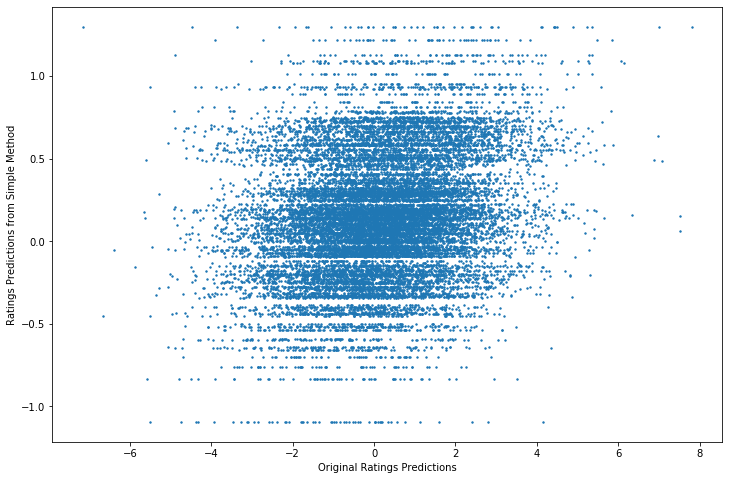

In [308]:
plt.figure(figsize=(12, 8))
plt.scatter(x = preds_og.flatten(), y = preds_dem.flatten(), s = 2)
plt.xlabel('Original Ratings Predictions')
plt.ylabel('Ratings Predictions from Simple Method')
plt.show()

In [309]:
#correlation metric
from scipy import stats
r, p = stats.pearsonr(preds_og.flatten(), preds_dem.flatten())
print('Pearson correlation between original predictions and new "simple method" predictions:', r, '\np-val:', p)

Pearson correlation between original predictions and new "simple method" predictions: 0.23621430566639673 
p-val: 1.1364524758200874e-251


There appears to be a weak linear relationship (seen by pearson corr value above) between the ratings predicted via the original 'full' model and the ratings predicted via the simple demographic model. While using the new predicted ratings based on the demographic model is definitely better than no existing vectors for new users, the new ratings don't accurately describe the original ratings. Therefore, this simple demographic method isn't ideal, as it doesn't get us more accurate rating predictions to build a robust recommendation system.

<font color='blue'> Now for each user, calculate the mean rating (according to the "full" model in Problem 1) for the 10 items recommended to that user, by each of the demopgraphic and "full" models. Output a scatterplot for the two mean ratings, where each point correpsonds to 1 user. 

In [310]:
avg_ratings_dem = []
for user in preds_dem:
    avg_rating = sum(user)/len(user)
    avg_ratings_dem.append(avg_rating)

In [311]:
avg_ratings_og = []
for user in preds_og:
    avg_rating = sum(user)/len(user)
    avg_ratings_og.append(avg_rating)

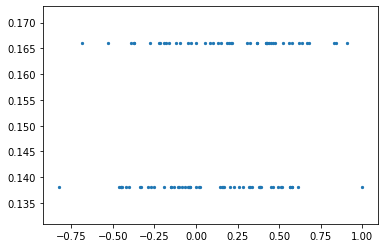

In [312]:
plt.scatter(x=avg_ratings_og, y=avg_ratings_dem, s=5)
plt.show()

In [313]:
diff = [y-x for y in avg_ratings_og for x in avg_ratings_dem]

In [314]:
import statistics as stats
stats.median(diff)

0.010079339480565441

In [315]:
#correlation metric
from scipy import stats
r, p = stats.pearsonr(avg_ratings_og, avg_ratings_dem)
print('Pearson correlation between avg original predictions and avg new "simple method" predictions:', r, '\np-val:', p)

Pearson correlation between avg original predictions and avg new "simple method" predictions: 0.1471750895598385 
p-val: 0.14395585077292963


<font color='blue'> Comment on the above. What is the "loss" from using demogprahics since we do not have access to the full data?

In [316]:
from sklearn.metrics import mean_squared_error

mean_squared_error(avg_ratings_og, avg_ratings_dem)

0.14132313108321148

We tend to decrease accuracy of recommendations for the new users lacking existing historical ratings information. There appears to be a very weak linear relationship (seen by pearson corr value above) between average ratings predicted by the original 'full' model and the simple demographic model. This means that the simple demographic model doesn't solve our cold start problem fully, and that more information to creating accurate user vectors for new users is needed. It should be noted that the MSE isn't that high, so we can consider this a reasonable method to predict new user vectors if we have no other better method at hand.

# Problem 3: Predictions under capacity constraints

Above, you should have observed that if we just recommend the top items for each user, some items get recommended quite a bit, and many items do not get recommended at all. Here, we are going to ask you to implement recommendations under capacity constraints.

Throughout this part, assume that you only have 5 copies of each item that you recommend, and that you will only recommend 1 item to each user. In other words, you cannot recommend the same item more than 5 times, and so there are exactly 1000 items in stock (representing 200 unique books) for your 1000 users. 

We'll continue exclusively using the "ratings with interaction0" data.

Now, let's assume that users are entering the platform sequentially in order of index. So the index 0 user comes first, index 1 user comes second, etc. 

### 3a) Naive recommendations under capacity constraints

<font color='blue'> First, let's pretend that we were naively recommending the predicted favorite item to each user. Of course, with unlimited capacity, each user would be recommended their predicted favorite. With capacity constraints, the favorite items of the users who come in later might already have reached their capacity, and so they have to be recommended an item further down their list. 
    
<font color='blue'> Do the following: simulate users coming in sequentially, in order of index. For each user, recommend to them their predicted favorite item that is still available. So the first user will get their favorite item, but the last few users will almost certainly not receive any of their top few predicted items. For each user, keep track of what the rank of the item that they were ultimately recommended was, according to the predicting ranking over items for that user.
    
<font color='blue'> Plot the resulting rankings in 2 ways: 1) A line plot, where the X axis is the user index and the Y axis is the rank of the item that they were recommended. and 2) A histogram of how often each rank shows up. (the X axis is the (binned) rank, and the Y axis is the count of that bin). 

In [375]:
inventory_left = [5]*200
ranks = [0]*1000
book_recs = []

preds_cap = get_predictions(user_vectors_interact0, book_vectors_interact0)
recs_cap = get_recommendations_for_each_user(preds_cap, number_top_items = 200)

for user, ratings in enumerate(recs_cap):
    for i, book in enumerate(ratings):
        if inventory_left[book] == 0:
            continue
        inventory_left[book] -=1
        ranks[user] += i
        book_recs.append(book)
        break

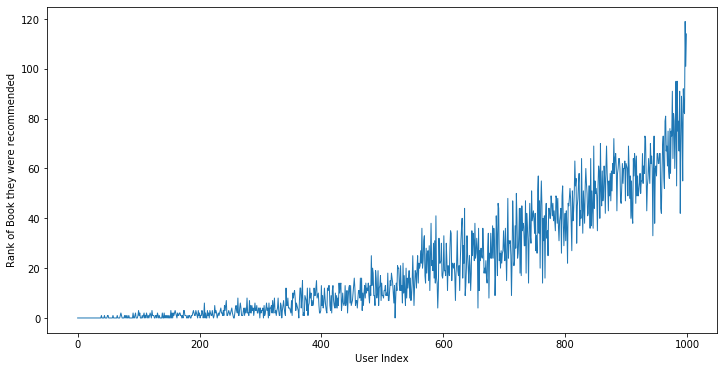

In [376]:
#1) A line plot, where the X axis is the user index and the Y axis is the rank of the item that they were recommended.
plt.figure(figsize=(12, 6))
plt.plot([i for i, user in enumerate(ranks)], ranks, linewidth=1)
plt.xlabel('User Index')
plt.ylabel('Rank of Book they were recommended')
plt.show()

In [377]:
from scipy.stats import linregress
linregress([i for i, user in enumerate(ranks)], ranks)

LinregressResult(slope=0.07035368235368238, intercept=-14.105664335664343, rvalue=0.8924184696643022, pvalue=0.0, stderr=0.0011259794410268121)

### Slope = 0.0704

Text(0, 0.5, 'Count that Each Rank is Recommended')

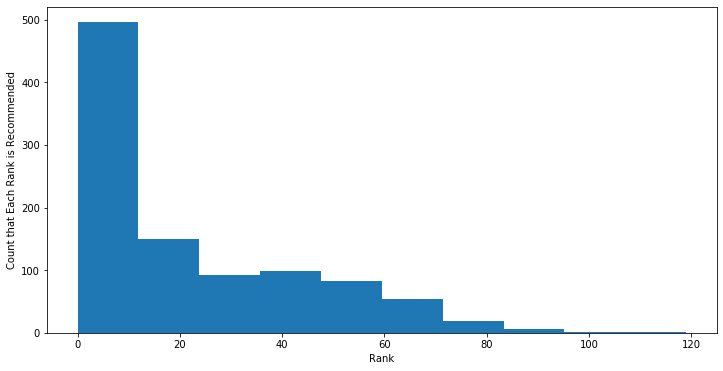

In [378]:
#A histogram of how often each rank shows up. (the X axis is the (binned) rank, and the Y axis is the count of that bin).
plt.figure(figsize=(12,6))
plt.hist(ranks)
plt.xlabel('Rank')
plt.ylabel('Count that Each Rank is Recommended')

### 3b) [Bonus -- 6 pts] Optimal recommendations under capacity constraints -- maximum weight matching

[3 points] <font color='blue'> Now let's do "optimal" recommendations with capacity, using maximum weight matching. Create the same two plots as above. <font color='blue'> Describe what you observe compared to the naive recommendations above. 
    
<font color='blue'>We suggest you use the `scipy.optimize.linear_sum_assignment` function. In that case, `np.tile` might also come in handy to create 5 copies of each items.  

[3 points] <font color='blue'> Of course, in reality you don't observe all the users at the same time -- they come in one by one, and you need to create a recommendation for the first user before the 50th user shows up. Here's let's pretend that users show up in batches of 100. So the first 100 users at the same time, next 100, etc. In this case, you can do "batched maximum weight matching," where you run maximum weight matching for the first 100 together to determine recommendations. Then, you do the same thing for the next 100 users with the items that are remaining, etc. 
    
<font color='blue'> Implement the above, show the same two plots as above, and describe what you observe. Note that this part requires careful attention for how many of each item remain after each round. 

you just need to create a cost matrix of size 1000x1000 where the rows are their preferences for each book. 

It's 1000 in length as you repeat the preferences 5 times. 


You throw this into the scipy method and it returns the column indices of the books which you can use to find the rankings

### 3c) Score functions for recommendations under capacity constraints

<font color='blue'>Here, we are working with just 200 items and 1000 users, and so batched maximum weight matching is feasible to run. In practice, with millions of items, that  might not be an effective strategy. Now, we ask you to implement the score function approach from class.

<font color='blue'> You should normalize the predicted ratings between 0 and 1 so that you are not dividing by a negative or close to 0 average rating before proceeding.
    
<font color='blue'> Implement the above and run the same simulation as part 3c, show the same two plots, and describe what you observe.

For this part, use the following score function:
    
$$\frac{r_{ij}}{\bar{r_{ij}}} \sqrt{C_j} $$



In [363]:
preds_cap_score = get_predictions(user_vectors_interact0, book_vectors_interact0)
recs_cap_score = get_recommendations_for_each_user(preds_cap_score, number_top_items = 200)

In [364]:
all_ratings = []
for rating in range(200):
    item_ratings = []
    for user in preds_cap_score:
        item_ratings.append(user[rating])
    all_ratings.append(item_ratings)

In [365]:
len(all_ratings)

200

In [366]:
new_all_ratings = []
for books_ratings in all_ratings:
    new_ratings = []
    minimum = min(books_ratings)
    maximum = max(books_ratings)
    for rating in books_ratings:
        new_rating = ((float(rating))-minimum)/(maximum-minimum)
        new_ratings.append(new_rating)
    new_all_ratings.append(new_ratings)

In [367]:
book_averages = []
for norm_ratings in new_all_ratings:
    average = sum(norm_ratings)/len(norm_ratings)
    book_averages.append(average)

In [368]:
book_averages[0]

0.500106679615711

In [369]:
new_preds = []
for user in range(1000):
    user_ratings = []
    for user_rating_l in new_all_ratings:
        user_ratings.append(user_rating_l[user])
    new_preds.append(user_ratings)

In [370]:
inventory_left = [5]*200 #sqrt this to calculate capacity
ranks = [0]*1000 #of

new_preds = np.array(new_preds)
for user in range(new_preds.shape[0]):
    ratings = new_preds[user, :]
    scores = (ratings / book_averages) * ((np.array(inventory_left))**0.5)
    recs = np.flip(np.argsort(scores))
#     print(recs)
    for rec in recs:
        book_is_not_available = inventory_left[rec] == 0
        if book_is_not_available:
            continue
        inventory_left[rec] -=1
        ranks[user] = recs_cap_score[user].index(rec)
        break

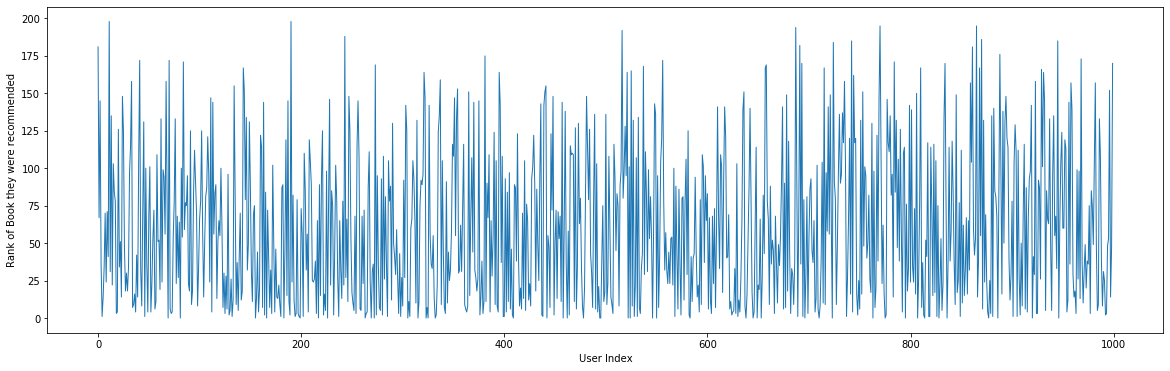

In [371]:
#1) A line plot, where the X axis is the user index and the Y axis is the rank of the item that they were recommended.
plt.figure(figsize=(20, 6))
plt.plot([i for i, user in enumerate(ranks)], ranks, linewidth=1)
plt.xlabel('User Index')
plt.ylabel('Rank of Book they were recommended')
plt.show()

In [372]:
from scipy.stats import linregress
linregress([i for i, user in enumerate(ranks)], ranks)

LinregressResult(slope=0.012423312423312424, intercept=53.94455544455544, rvalue=0.07011602381898031, pvalue=0.02660810021124402, stderr=0.005594801364354531)

### Slope = 0.0124

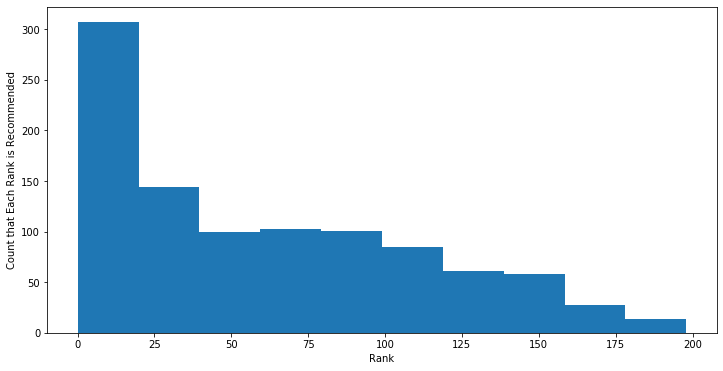

In [373]:
plt.figure(figsize=(12,6))
plt.hist(ranks)
plt.xlabel('Rank')
plt.ylabel('Count that Each Rank is Recommended')
plt.show()

**Observation**: While I know that my line plot and histogram for capacity implementation isn't the ideal solution, I calculate the slope to compare whether or not my implementation of capacity constraints help to recommend more users later on in the 'virtual waiting line' their most preferred item. The slope in my capacity constratins implementation line plot decreases by about .05, which shows a decrease in the rate that most prefered items are NOT recommended to users, suggesting a slight improvement to our naive method in 3a. However, my histogram shows that the number of most preferred items that are recommended to users decreases (from a little below 500 times in 3a to around 300 times in 3c). This suggests an error in my algorithm which incorrectly tracks the capacity of items in the remaining inventory.

Comment for entire homework: In this homework, we haven't been careful with what is "training" data and what is "test" data. For example, in 3c, you're using average ratings from customers who haven't shown up yet in your simulation. In Problem 2, when training the user/book vectors we used data from customers that we are then pretending we haven't seen data from. In practice, and for the class project, you should be more careful. Such train/test/validation pipelines should be a core part of what you learn in machine learning classes. 